In [24]:
def preprocesamiento(df):

    import pandas as pd
    import numpy as np
    
    import warnings
    warnings.filterwarnings('ignore')
    
    
#    df = pd.read_csv("Esophageal_Dataset.csv")
    cols_to_drop = ['Unnamed: 0',
                    'patient_barcode',
                    'tissue_source_site',
                    'patient_id',
                    'bcr_patient_uuid',
                    'informed_consent_verified',
                    'icd_o_3_site',
                    'country_of_birth',
                    'country_of_procurement', 
                    'state_province_of_procurement',
                    'city_of_procurement',
                    'history_of_neoadjuvant_treatment', 
                    'age_began_smoking_in_years',
                    'stopped_smoking_year',
                    'number_pack_years_smoked',
                    'frequency_of_alcohol_consumption',
                    'amount_of_alcohol_consumption_per_day',
                    'antireflux_treatment_types',
                    'h_pylori_infection',
                    'goblet_cells_present',
                    'number_of_relatives_diagnosed',
                    'day_of_form_completion',
                    'month_of_form_completion',
                    'year_of_form_completion',
                    'project',
                    'stage_event_system_version',
                    'stage_event_psa',
                    'stage_event_gleason_grading',
                    'stage_event_ann_arbor',
                    'stage_event_serum_markers',
                    'stage_event_igcccg_stage',
                    'stage_event_masaoka_stage',
                    'primary_pathology_tumor_tissue_site',
                    'primary_pathology_esophageal_tumor_involvement_sites',
                    'primary_pathology_columnar_metaplasia_present',
                    'primary_pathology_columnar_mucosa_goblet_cell_present',
                    'primary_pathology_columnar_mucosa_dysplasia',
                    'primary_pathology_days_to_initial_pathologic_diagnosis',
                    'primary_pathology_year_of_initial_pathologic_diagnosis',
                    'primary_pathology_init_pathology_dx_method_other',
                    'primary_pathology_number_of_lymphnodes_positive_by_he',
                    'primary_pathology_number_of_lymphnodes_positive_by_ihc',
                    'primary_pathology_planned_surgery_status',
                    'primary_pathology_treatment_prior_to_surgery',
                    'primary_pathology_karnofsky_performance_score',
                    'primary_pathology_eastern_cancer_oncology_group',
                    'days_to_last_followup',
                    'days_to_death']
    
    df.drop(columns=cols_to_drop, inplace=True)
    
#se harán dummies para los indicadores histológicos icd_o_3 & icd_10
    
#rellenamos nans de prospective collection con método bfill, y usamos prospective collection para crear columna tissue collection:
#con valor 1 para prospective (prospective=YES) y 0 para retrospective (prospective=NO)
#y eliminaremos las columnas prospective y retrospective
    df.tissue_prospective_collection_indicator = df.tissue_prospective_collection_indicator.fillna(method='bfill')
    df['tissue_collection'] = df['tissue_prospective_collection_indicator']
    
    df.loc[(df['tissue_prospective_collection_indicator'] == 'YES'), 'tissue_collection'] = 1
    df.loc[(df['tissue_prospective_collection_indicator'] == 'NO'), 'tissue_collection'] = 0
  
    
#se crea una columna edad que contendrá la edad en años (módulo de la division por 365 de la columna days_to_birth)
#y se crea una columna de años sobrevividos con la diferencia entre edad y edad de diagnóstico
#(para casos en los que la diferencia es -1 por ajuste del modulo, se fuerza valor 0)
#se escala usando minmax scaling
#por último se eliminará la columna original days_to_birth
    df['age'] = df.days_to_birth // -365
    df['years_survived']=df.age - df.primary_pathology_age_at_initial_pathologic_diagnosis
    df.loc[df.years_survived < 0, 'years_survived'] = 0
    df.age = (df.age - df.age.min()) / (df.age.max() - df.age.min())
    
#se crean dummies para sexo
#se eliminará la columna original después de haber calculado las medias de altura y peso por sexo
#para rellenar los NaN de esas columnas 
#se escalan min_max la altura y el peso    
    df.loc[(df.height.isna()) & (df.gender == 'FEMALE'), 'height'] = df.loc[(df.gender == 'FEMALE'), 'height'].mean()
    df.loc[(df.height.isna()) & (df.gender == 'MALE'), 'height'] = df.loc[(df.gender == 'MALE'), 'height'].mean()
    df.height = (df.height - df.height.min()) / (df.height.max() - df.height.min())
    
    df.loc[(df.weight.isna()) & (df.gender == 'FEMALE'), 'weight'] = df.loc[(df.gender == 'FEMALE'), 'weight'].mean()
    df.loc[(df.weight.isna()) & (df.gender == 'MALE'), 'weight'] = df.loc[(df.gender == 'MALE'), 'weight'].mean()
    df.weight = (df.weight - df.weight.min()) / (df.weight.max() - df.weight.min())

    
#Los NaN de la columna race_list se rellenará de la siguiente forma:
#en los casos en los que sea NAN y la columna 'ethnicity' sea HISPANIC, se rellenará como HISPANIC… 
#los demás NAN se rellenárán usando el método backfill.
#se crean dummies para la columna y se eliminará la columna 'ethnicity'
    df.loc[(df.race_list.isna()) & (df.ethnicity == 'HISPANIC OR LATINO'), 'race_list'] = 'HISPANIC'
    df.race_list = df.race_list.fillna(method='bfill')
    
#valores YES/NO de other_dx pasan a ser 1/0
    df.loc[df.other_dx == 'Yes', 'other_dx'] = 1
    df.loc[df.other_dx == 'No', 'other_dx'] = 0
    
#valores TUMOR FREE/WITH TUMOR de person_neoplasm_cancer_status pasan a ser 0/1
#y NaN se cambian con método ffill
    df.loc[df.person_neoplasm_cancer_status == 'TUMOR FREE', 'person_neoplasm_cancer_status'] = 0
    df.loc[df.person_neoplasm_cancer_status == 'WITH TUMOR', 'person_neoplasm_cancer_status'] = 1
    df.person_neoplasm_cancer_status = df.person_neoplasm_cancer_status.fillna(method='ffill')
    
#valores Dead/Alive de vital_status pasan a ser 0/1
    df.loc[df.vital_status == 'Dead', 'vital_status'] = 0
    df.loc[df.vital_status == 'Alive', 'vital_status'] = 1
    
#historial de fumador: sustituimos NaN con método ffill y hacemos dummies para los valores 1,2,3,4. 
    df.tobacco_smoking_history = df.tobacco_smoking_history.fillna(method='ffill')
   
    
#historial de alcohol: pasar Yes/No a 1/0 y rellenar NaN con backfill
    df.loc[df.alcohol_history_documented == 'NO', 'alcohol_history_documented'] = 0
    df.loc[df.alcohol_history_documented == 'YES', 'alcohol_history_documented'] = 1
    df.alcohol_history_documented = df.alcohol_history_documented.fillna(method='bfill')
    
#historial de reflujo: pasar Yes/No a 1/0 y rellenar NaN con backfill
    df.reflux_history = df.reflux_history.fillna(method='ffill')
    df.loc[(df.reflux_history == 'NO') | (df.reflux_history.isna()), 'reflux_history'] = 0
    df.loc[df.reflux_history == 'YES', 'reflux_history'] = 1
    
    
#diagnóstico inicial: pasar Symptomatic/Screening/Surveillance a 1/2/3 
#rellenar NaN con frontfill y get_dummies
    df.initial_diagnosis_by = df.initial_diagnosis_by.fillna(method='ffill')

    
#barretts_esophagus: Yes/No a 1/0 y rellenar NaN con frontfill
    df.loc[df.barretts_esophagus  == 'No', 'barretts_esophagus'] = 0
    df.loc[df.barretts_esophagus  == 'Yes-USA', 'barretts_esophagus'] = 1
    df.loc[df.barretts_esophagus  == 'Yes-UK', 'barretts_esophagus'] = 1 
    df.barretts_esophagus = df.barretts_esophagus.fillna(method='ffill')
    
#historial de cáncer de esófago: pasar Yes/No a 1/0 y rellenar NaN con backfill
    df.history_of_esophageal_cancer = df.history_of_esophageal_cancer.fillna(method='ffill')
    df.loc[(df.history_of_esophageal_cancer == 'NO') | (df.history_of_esophageal_cancer.isna()), 'history_of_esophageal_cancer'] = 0
    df.loc[df.history_of_esophageal_cancer == 'YES', 'history_of_esophageal_cancer'] = 1
    
    
#nuevos eventos tumorales: pasar Yes/No a 1/0
    df.loc[df.has_new_tumor_events_information == 'NO', 'has_new_tumor_events_information'] = 0
    df.loc[df.has_new_tumor_events_information == 'YES', 'has_new_tumor_events_information'] = 1
    
#le hacen seguimientos: pasar Yes/No a 1/0
    df.loc[df.has_follow_ups_information == 'NO', 'has_follow_ups_information'] = 0
    df.loc[df.has_follow_ups_information == 'YES', 'has_follow_ups_information'] = 1
    
#pautan medicación tumorales: pasar Yes/No a 1/0
    df.loc[df.has_drugs_information == 'NO', 'has_drugs_information'] = 0
    df.loc[df.has_drugs_information == 'YES', 'has_drugs_information'] = 1
    
#pautan radiación: pasar Yes/No a 1/0
    df.loc[df.has_radiations_information == 'NO', 'has_radiations_information'] = 0
    df.loc[df.has_radiations_information == 'YES', 'has_radiations_information'] = 1
    
#Combinamos las columnas stage_event_clinical_stage y stage_event_pathologic_stage en una única columna stage
#tomando como referencia el valor de stage_event_pathologic_stage, y cuando este es NaN
#tomando el valor de stage_event_clinical_stage.
    df['stage'] = np.where(~df['stage_event_pathologic_stage'].isna(), 
                           df['stage_event_pathologic_stage'], 
                           df['stage_event_clinical_stage'])
    
#Para aquellos casos en los que no está informado ni el estadio clínico ni patológico
#utilizaremos el valor T y N de la columna stage_event_tnm_categories para establecer el Stage
#Para ello, creamos las siguientes máscaras booleanas según la clasificación de stages
#para cáncer de esófago a partir de valores TNM encontrado online:

    #Stage I: T1, N0, M0
    #Stage II: T2, N0, M0 or T3, N0, M0 ...incluyo aquí los T2NX por ser Stage II mayoría
    #Stage III: T1-3, N1, M0 or T4, N0-1, M0
    #Stage IV: T1-4, N2-3, M0 or T1-4, N0-3, M1
    
    bool_mask_1 = ((df['stage_event_tnm_categories'].str[1].str.match('1').fillna(False)) & 
                   (df['stage_event_tnm_categories'].str[3].str.match('0').fillna(False)))
    
    bool_mask_2 = (((df['stage_event_tnm_categories'].str[1].str.match('2').fillna(False)) & 
                    (df['stage_event_tnm_categories'].str[3].str.match('0').fillna(False))) |
                   ((df['stage_event_tnm_categories'].str[1].str.match('2').fillna(False)) & 
                    (df['stage_event_tnm_categories'].str[3].str.match('X').fillna(False))) |
                   ((df['stage_event_tnm_categories'].str[1].str.match('3').fillna(False)) & 
                    (df['stage_event_tnm_categories'].str[3].str.match('0').fillna(False))))
    
    bool_mask_3 = (((df['stage_event_tnm_categories'].str[1].str.match('1').fillna(False)) & 
                    (df['stage_event_tnm_categories'].str[3].str.match('1').fillna(False))) |               
                   ((df['stage_event_tnm_categories'].str[1].str.match('2').fillna(False)) & 
                    (df['stage_event_tnm_categories'].str[3].str.match('1').fillna(False))) |
                   ((df['stage_event_tnm_categories'].str[1].str.match('3').fillna(False)) & 
                    (df['stage_event_tnm_categories'].str[3].str.match('1').fillna(False))) |
                   ((df['stage_event_tnm_categories'].str[1].str.match('4').fillna(False)) & 
                    (df['stage_event_tnm_categories'].str[3].str.match('0').fillna(False))) |
                   ((df['stage_event_tnm_categories'].str[1].str.match('4').fillna(False)) & 
                    (df['stage_event_tnm_categories'].str[3].str.match('1').fillna(False))))
    
    bool_mask_4 = (((df['stage_event_tnm_categories'].str[1].str.match('1').fillna(False)) & 
                    (df['stage_event_tnm_categories'].str[3].str.match('2').fillna(False))) |               
                   ((df['stage_event_tnm_categories'].str[1].str.match('2').fillna(False)) & 
                    (df['stage_event_tnm_categories'].str[3].str.match('2').fillna(False))) |
                   ((df['stage_event_tnm_categories'].str[1].str.match('3').fillna(False)) & 
                    (df['stage_event_tnm_categories'].str[3].str.match('2').fillna(False))) |
                   ((df['stage_event_tnm_categories'].str[1].str.match('4').fillna(False)) & 
                    (df['stage_event_tnm_categories'].str[3].str.match('2').fillna(False))) |
                   ((df['stage_event_tnm_categories'].str[1].str.match('1').fillna(False)) & 
                    (df['stage_event_tnm_categories'].str[3].str.match('3').fillna(False))) |               
                   ((df['stage_event_tnm_categories'].str[1].str.match('2').fillna(False)) & 
                    (df['stage_event_tnm_categories'].str[3].str.match('3').fillna(False))) |
                   ((df['stage_event_tnm_categories'].str[1].str.match('3').fillna(False)) & 
                    (df['stage_event_tnm_categories'].str[3].str.match('3').fillna(False))) |
                   ((df['stage_event_tnm_categories'].str[1].str.match('4').fillna(False)) & 
                    (df['stage_event_tnm_categories'].str[3].str.match('3').fillna(False))))
    
    #Aplicamos la máscara
    mask_na = df['stage'].isna()
    df.loc[mask_na, 'stage'] = np.select([bool_mask_1[df['stage'].isna()], 
                                          bool_mask_2[df['stage'].isna()], 
                                          bool_mask_3[df['stage'].isna()],
                                          bool_mask_4[df['stage'].isna()]], 
                                         ['Stage I', 'Stage II', 'Stage III', 'Stage IV'], 
                                            default=np.nan)
    
#Simplificamos los valores de Stage a Stage I, Stage II, Stage III y Stage IV eliminando sufijos, previo a pasar a dummies
    df['stage'] = df['stage'].str.removesuffix('A').str.removesuffix('B').str.removesuffix('C')
      
#eliminaremos las columnas de clinical_stage, pathologic_stage y tnm_categories
    
    
#rellenamos los pocos valores NaN de primary_pathology_esophageal_tumor_cental_location 
#con Distal por ser el valor más frecuente y hacemos get_dummies para los tres valores: Distal, Mid, Proximal
    df.primary_pathology_esophageal_tumor_cental_location = df.primary_pathology_esophageal_tumor_cental_location.fillna('Distal')

    
#primary_pathology_histological_type: renombramos y hacemos get_dummies antes de eliminar columna original
    df.loc[(df['primary_pathology_histological_type']=='Esophagus Adenocarcinoma, NOS'), 
            'primary_pathology_histological_type'] = 'Adeno-NOS'
    df.loc[(df['primary_pathology_histological_type']=='Esophagus Squamous Cell Carcinoma'), 
            'primary_pathology_histological_type'] = 'ESCC'
   
    
#primary_pathology_neoplasm_histologic_grade: get_dummies

    
#primary_pathology_age_at_initial_pathologic_diagnosis: escalar min_max
    df.primary_pathology_age_at_initial_pathologic_diagnosis = (df.primary_pathology_age_at_initial_pathologic_diagnosis - df.primary_pathology_age_at_initial_pathologic_diagnosis.min()) / (df.primary_pathology_age_at_initial_pathologic_diagnosis.max() - df.primary_pathology_age_at_initial_pathologic_diagnosis.min())
    
#primary_pathology_initial_pathologic_diagnosis_method:
#valores: biopsy/surgery/other
#la columna primary_pathology_init_pathology_dx_method_other (elimiada) informa de los posibles 'other':
#que en la gran mayoría de casos son surgical resection… por tanto, dejaremos solo dos alores biopsy/resection
#y en el último incluiremos los other y NaN de la columna, para después crear dummies
    df.loc[df['primary_pathology_initial_pathologic_diagnosis_method'] == 'Endoscopic Biopsy', 'primary_pathology_initial_pathologic_diagnosis_method'] = 'Biopsy'
    df.loc[df['primary_pathology_initial_pathologic_diagnosis_method'] != 'Endoscopic Biopsy', 'primary_pathology_initial_pathologic_diagnosis_method'] = 'Resection'
    df.primary_pathology_initial_pathologic_diagnosis_method = df.primary_pathology_initial_pathologic_diagnosis_method.fillna('Resection')

    
#primary_pathology_lymph_node_metastasis_radiographic_evidence: 
#rellenar NaN en función de si en 'stage' es StageIV (YES) o no (NO), y hacer dummies
#borrar esta fila y stage
    
    bool_mask_stage = df.stage.str.match('Stage IV').fillna(False)
    bool_mask_no_stage = ((df.stage.str.match('Stage III').fillna(False)) |
                          (df.stage.str.match('Stage II').fillna(False)) |
                          (df.stage.str.match('Stage I').fillna(False)))
    mask_stage = df.primary_pathology_lymph_node_metastasis_radiographic_evidence.isna()
    df.loc[mask_stage, 'primary_pathology_lymph_node_metastasis_radiographic_evidence'] = np.select([bool_mask_stage[df['primary_pathology_lymph_node_metastasis_radiographic_evidence'].isna()], 
                                                                                                     bool_mask_no_stage[df['primary_pathology_lymph_node_metastasis_radiographic_evidence'].isna()]], 
                                                                                                    ['YES', 'NO'],
                                                                                                    default=np.nan)
        
#primary_pathology_primary_lymph_node_presentation_assessment. Rellenar NaN con method bfill
    df.primary_pathology_primary_lymph_node_presentation_assessment = df.primary_pathology_primary_lymph_node_presentation_assessment.fillna(method='bfill')

    
    
#primary_pathology_lymph_node_examined_count:
#se rellenarán los NaN como 0 si primary_lymph_node_presentation es 'NO' o con la media de recuento si es 'YES' (14.0)
#después se dividirán en 4 grupos según la clasificación descrita por The Cleveland Journal of Medicine
#de la clasificación TNM para el cáncer de esófago: 
#0 (N0), 1-2 (N1), 3-6 (N2), 7 o más (N3)
    bool_mask_lymph = df.primary_pathology_primary_lymph_node_presentation_assessment.str.match('YES').fillna(False)
    bool_mask_no_lymph = df.primary_pathology_primary_lymph_node_presentation_assessment.str.match('NO').fillna(False)
    
    mask_lymph_count = df.primary_pathology_lymph_node_examined_count.isna()
    mean_count = round(df.primary_pathology_lymph_node_examined_count.mean(),0)
    df.loc[mask_lymph_count, 'primary_pathology_lymph_node_examined_count'] = np.select([bool_mask_lymph[df['primary_pathology_lymph_node_examined_count'].isna()], 
                                                                                                     bool_mask_no_lymph[df['primary_pathology_lymph_node_examined_count'].isna()]], 
                                                                                                    [mean_count, 0.0],
                                                                                                    default=np.nan)
    df.loc[(df['primary_pathology_lymph_node_examined_count'] == 0.0), 'lymph_node_count'] = 'N0'
    df.loc[(df['primary_pathology_lymph_node_examined_count'] >= 1.0) & (df['primary_pathology_lymph_node_examined_count'] <= 2.0), 'lymph_node_count'] = 'N1'
    df.loc[(df['primary_pathology_lymph_node_examined_count'] >= 3.0) & (df['primary_pathology_lymph_node_examined_count'] <= 6.0), 'lymph_node_count'] = 'N2'
    df.loc[(df['primary_pathology_lymph_node_examined_count'] >= 7.0), 'lymph_node_count'] = 'N3'
    
#primary_pathology_residual_tumor: rellenamos NaN con forward fill, y demás valores pasan a dos grupos: No (R0) & Yes (R1/R2/RX), then get_dummies
    
    df.primary_pathology_residual_tumor = df.primary_pathology_residual_tumor.fillna(method='ffill')
    df.loc[(df['primary_pathology_residual_tumor'] == 'R0'),'primary_pathology_residual_tumor'] = 'NO'
    df.loc[(df['primary_pathology_residual_tumor'] != 'R0'),'primary_pathology_residual_tumor'] = 'YES'

    
    #primary_pathology_radiation_therapy
    df.primary_pathology_radiation_therapy = df.primary_pathology_radiation_therapy.fillna(method='ffill')

    
    #primary_pathology_postoperative_rx_tx 
    df.primary_pathology_postoperative_rx_tx = df.primary_pathology_postoperative_rx_tx.fillna(method='bfill')
    
    cols_to_dummies = ['icd_o_3_histology', 'icd_10', 'gender', 'race_list', 'tobacco_smoking_history', 'initial_diagnosis_by', 'stage', 
                         'primary_pathology_esophageal_tumor_cental_location', 'primary_pathology_histological_type', 'primary_pathology_neoplasm_histologic_grade',
                         'primary_pathology_initial_pathologic_diagnosis_method', 'primary_pathology_lymph_node_metastasis_radiographic_evidence',
                         'primary_pathology_primary_lymph_node_presentation_assessment', 'lymph_node_count', 'primary_pathology_residual_tumor',
                         'primary_pathology_radiation_therapy', 'primary_pathology_postoperative_rx_tx']
    
#    cols_to_concat = ['tissue_collection','age','years_survived', 'height', 'weight', 'other_dx', 'person_neoplasm_cancer_status', 'vital_status', 'alcohol_history_documented',
#                     'reflux_history', 'barretts_esophagus', 'history_of_esophageal_cancer','has_new_tumor_events_information', 'has_follow_ups_information', 'has_drugs_information',
#                     'has_radiations_information', 'primary_pathology_age_at_initial_pathologic_diagnosis']
    
    
    df_final = pd.get_dummies(data=df, columns=cols_to_dummies, drop_first=True)
    df_final.drop(columns=['tissue_prospective_collection_indicator', 'tissue_retrospective_collection_indicator', 'days_to_birth', 
                           'ethnicity', 'stage_event_clinical_stage', 'stage_event_pathologic_stage', 'stage_event_tnm_categories', 
                           'primary_pathology_lymph_node_examined_count'], inplace=True)
    df_final=df_final.astype("float")
    df_final.to_csv('Esophageal_Dataset_clean.csv')
    return(df_final)


In [32]:
def KNN(data, target,k):
    import pandas as pd
    import numpy as np
    from sklearn.metrics import accuracy_score
    from sklearn import datasets
    import matplotlib.pyplot as plt
    from sklearn.neighbors import KNeighborsClassifier
#    from sklearn.neighbors import RadiusNeighborsClassifier
    import warnings
    warnings.filterwarnings('ignore')

    from sklearn.model_selection import train_test_split
    X = data.drop(columns=[target])
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

    clasificador = KNeighborsClassifier(k, algorithm="brute") # creo el obj/cajita
    clasificador.fit(X_train, y_train) # entreno con el fit
    yhat = clasificador.predict(X_test) # hago la prediccion
    acc = accuracy_score(y_test, yhat)
    return acc

In [34]:
def repeat_KNN_train_test(data,target,k, num_models=10):
    acc_mean=np.mean([KNN(data, target, k) for i in range(num_models)])
    acc_std = np.std([KNN(data, target, k) for i in range(num_models)])
    return acc_mean, acc_std

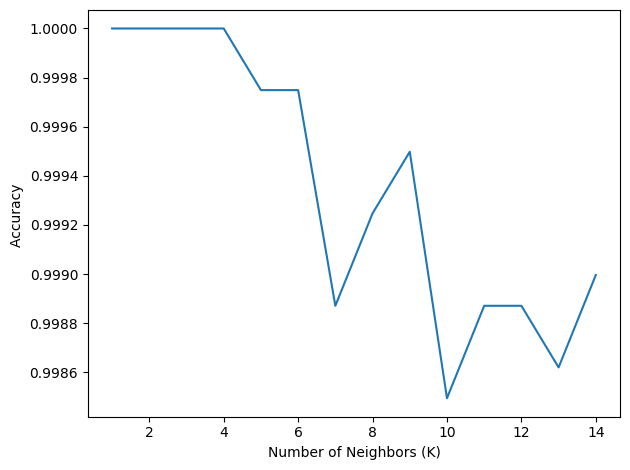

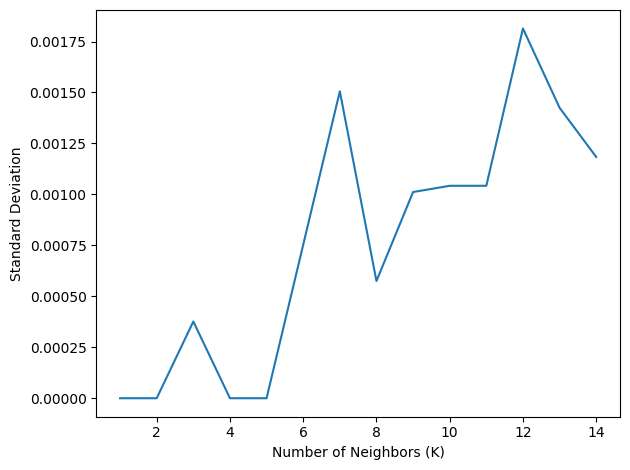

In [45]:
df = pd.read_csv("Esophageal_Dataset.csv")
data = preprocesamiento(df)

cols_to_model = ['height', 'weight', 'other_dx', 'alcohol_history_documented', 'reflux_history',
       'barretts_esophagus', 'history_of_esophageal_cancer', 'vital_status', 'age', 
       'race_list_BLACK OR AFRICAN AMERICAN', 'race_list_HISPANIC',
       'race_list_WHITE', 'tobacco_smoking_history_2.0',
       'tobacco_smoking_history_3.0', 'tobacco_smoking_history_4.0',
       'initial_diagnosis_by_Surveillance', 'initial_diagnosis_by_Symptomatic',
       'primary_pathology_esophageal_tumor_cental_location_Mid',
       'primary_pathology_esophageal_tumor_cental_location_Proximal', 'primary_pathology_histological_type_ESCC']

data_model = pd.DataFrame(data=data, columns=cols_to_model)
#KNN(data_model, 'primary_pathology_histological_type_ESCC')
#RadiusNeighboursClassifier(data_model, 'primary_pathology_histological_type_ESCC')

mean_accuracies=[repeat_KNN_train_test(data_model,'primary_pathology_histological_type_ESCC',k)[0] for k in range(1, 15)]
mean_std=[repeat_KNN_train_test(data_model,'primary_pathology_histological_type_ESCC',k)[1] for k in range(1, 15)]

plt.plot(np.arange(1,15), mean_accuracies)
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout() #Ajusta automáticamente los parámetros de la subtrama
plt.show()

plt.plot(np.arange(1,15), mean_std)
plt.ylabel('Standard Deviation')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout() #Ajusta automáticamente los parámetros de la subtrama
plt.show()

In [ ]:
## MEJOR K ES 2 o 4 por mayor accuracy y menor standard deviation, lo hace más estable

In [95]:
accuracy2 = KNN(data_model, 'primary_pathology_histological_type_ESCC', 2)
accuracy4 = KNN(data_model, 'primary_pathology_histological_type_ESCC', 4)
print("KNN accuracy with k=2: ", accuracy2)
print("KNN accuracy with k=4: ", accuracy4)

KNN accuracy with k=2:  0.9974905897114178
KNN accuracy with k=4:  1.0
